<a href="https://colab.research.google.com/github/pjuvm/BCI-lab-1/blob/project1/BCI_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pylab import *
from collections import Counter
import matplotlib.pyplot as plt
!pip install mne
import mne
from mne.stats import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 19.0 MB/s eta 0:00:00


In [2]:
os.listdir()

['.config', 'drive', 'sample_data']

In [3]:
!git clone --branch project1 https://github.com/pjuvm/BCI-lab-1.git

Cloning into 'BCI-lab-1'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 95 (delta 29), reused 26 (delta 6), pack-reused 30
Receiving objects: 100% (95/95), 107.91 MiB | 13.10 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (30/30), done.


In [4]:
os.chdir("BCI-lab-1")

In [31]:
import loadmat
import load_p300_data
import plot_p300_erps

#Parts C,D, and E

In [32]:
def subject_epoch_groups(subject):
  """ This function takes the .mat file from each subject in the P300 speller experiment
  and epochs the data, separating the epochs into two groups: target and nontarget.
  Each array is of shape of (n_samples, samples_per_epoch, n_channels)
  """

  eeg_time, eeg_data, rowcol_id, is_target = load_p300_data.load_training_eeg(subject = subject)
  event_sample, is_target_event = plot_p300_erps.get_events(rowcol_id, is_target)
  eeg_epochs, erp_times = plot_p300_erps.epoch_data(eeg_time, eeg_data, event_sample, epoch_start_time = -0.5, epoch_end_time = 1)
  target_epochs = eeg_epochs[is_target_event]
  nontarget_epochs = eeg_epochs[~is_target_event]
  return target_epochs.astype(float), nontarget_epochs.astype(float)

def erp_difference(EEG1,EEG2):
  """ this functions finds the absolute value of the difference between the ERPs of two EEG groups
  Args:
    EEG1: 3d array of (trials, time points, channels)
    EEG2: same as EEG1 above.
  Returns:
    Absolute value of difference between ERP (mean EEG) of two groups
  """
  target_ERP = EEG1[:,:,:].mean(0)
  nontarget_ERP = EEG2[:,:,:].mean(0)
  return np.abs(target_ERP - nontarget_ERP)

In [33]:
def p_value_gen(EEG1, EEG2, n_iter = 500, channel = 0, alpha = 0.05, random_seed=888):
  """ Function that generates a array of p-values of size (time points, channels)
  relating real data to bootstrapped data; viz probabilities of real data given the bootstrapped sample data
  Args:
    EEG1 -- array of shape (samples, time, channels)
    EEG2 -- as above
    n_iter -- number of bootstrap iterations
    channel -- int. The EEG channel to generate p-values for
  Returns:
    p-values: array of length samples_per_epoch, containing bootstrapped p-values for each sample in the epoch. These are not corrected for multiple trials.
    significance list: an array (variable) that indexes where significant p-values (according to alpha significance level above) occur during the epoch.
  """
  np.random.seed(random_seed)
  combined_epochs = np.vstack([EEG1,EEG2])
  real_erp_diff = erp_difference(EEG1,EEG2)  #the real ERP difference between two groups or conditions
  score = np.zeros(EEG1.shape[1],)                      #zero matrix to count significance
  for bootstrap_iter in range(n_iter):
    inds = np.random.randint(0,len(combined_epochs),len(combined_epochs))
    bootstrapped_epochs = combined_epochs[inds]
    bootstrap_target = bootstrapped_epochs[:EEG1.shape[0]] #use same number of trials eg 150 as data
    bootstrap_nontarget = bootstrapped_epochs[EEG2.shape[0]:] #use same number of trials eg 750 as data
    #bootstrapped nontarget ERP, mean of the 750 samples
    bootstrap_erp_diff_array = erp_difference(bootstrap_target,bootstrap_nontarget) #absolute difference of the two as statistic
    #print(bootstrap_erp_diff_array.shape)

    x = (bootstrap_erp_diff_array[:,channel] > real_erp_diff[:,channel]).astype(int) #whenever a bootstrap value is larger than the real data add 1
    score += x

  return score/n_iter, np.where(score/n_iter < alpha) #calculate percentage of bootstrap samples bigger than the real data

In [8]:
def find_significant_times(channel, subjects, alpha = 0.05, samples_per_epoch=384, n_iter=500, random_seed=888):
  np.random.seed(random_seed)
  score = np.zeros(samples_per_epoch,)
  for subj in subjects:
    EEGa,EEGb = subject_epoch_groups(subj)  #split data into two conditions or groups of EEG
    my_raw_pvals = p_value_gen(EEG1 = EEGa, EEG2 = EEGb, n_iter = 500, channel = channel, alpha = 0.05)   #get the uncorrected p-values
    mask = fdr_correction(my_raw_pvals[0], alpha = alpha)[0]   #false discovery rate correction for the p-values
    mask = mask.astype(int)     #takes boolean mask converts to binary matrix of 1s and 0s
    score += mask               #adds the above matrix to the score matrix, to tally significant time points across subjects
  my_mask = np.where(score != 0)
  #erp_times = np.linspace(-0.5,1.0,384)

  return score

In [10]:
M6 = find_significant_times(channel = 6, subjects = [3,4,5,6,7,8,9,10], n_iter = 3000)

In [11]:
M0 = find_significant_times(channel = 0, subjects = [3,4,5,6,7,8,9,10], n_iter = 3000)

In [12]:
M1 = find_significant_times(channel = 1, subjects = [3,4,5,6,7,8,9,10], n_iter = 3000)

In [34]:
M2 = find_significant_times(channel = 2, subjects = [3,4,5,6,7,8,9,10], n_iter = 3000)

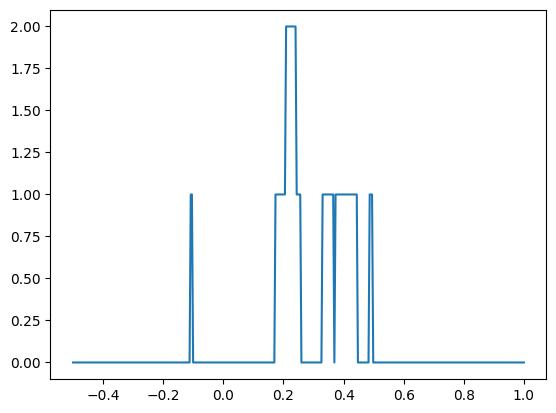

In [13]:
plt.plot(np.linspace(-0.5,1,384), M0)

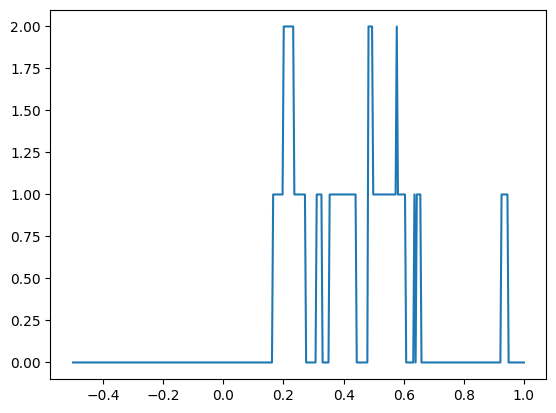

In [14]:
plt.plot(np.linspace(-0.5,1,384), M1)

#Part F

In [15]:
def erp_group_median(subjects):
  """
  function that takes EEG data from various subjects, finds the median per subject, and then finds the median of the medians.
  Args:
    subjects: list of subjects by number
  Returns
    group_median_erp: array of length samples_per_epoch
  """

  subject_median_ERPs = []
  for subj in subjects:
    eeg_time, eeg_data, rowcol_id, is_target = load_training_eeg(subject = subj)

    event_sample, is_target_event = get_events(rowcol_id, is_target)
    eeg_epochs, erp_times = epoch_data(eeg_time, eeg_data, event_sample, epoch_start_time = -0.5, epoch_end_time = 1)

    #find the median of the subject at hand
    subj_median = np.median(eeg_epochs, 0)
    #append subject's median to a list of such medians
    subject_median_ERPs.append(subj_median)
    #take list and created 3d array of shape (n_subjects, samples_per_epoch, channels)
    stacked_median_erps = np.stack(subject_median_ERPs)
    #find the median of those medians
    group_median_erp = np.median(stacked_median_erps, axis = 0)
    return group_median_erp

In [16]:
#N2 -- 175-250ms after onset of stimulus
#P3b -- 300ms after onset of stimulus
"""
To address this possibility, the present study explores the value of incorporating information from electrode locations
that are not traditionally associated with the P300 response.
In addition, several data preprocessing and model parameters are evaluated to assess
the relative effects with respect to the new spatial information.
Using a SWLDA classifier, both offline and online results obtained from 64-channel data
show that some of the most discriminable EEG features evoked by the P300 speller occur
at posterior electrodes (namely PO7, PO8, Oz), and that these
features can significantly improve classification performance
when used in conjunction with the classical P300 feature space
(i.e., EEG features at electrodes Fz, Cz, Pz [20]).

"""

channel_names = ["Fz", "Cz","Pz","Oz","P3","P4","PO7","PO8"]

In [17]:
gmedianERP = erp_group_median(subjects = [3,4,5,6,7,8,9,10])
gmedianERP

array([[0.24778848830047195, 0.45698914886119013, 0.4660864230432509,
        ..., -0.00280193035476492, -0.2634439589704982,
        -0.2292430555287055],
       [0.3831981281707293, 0.4181641575834796, 0.4697096423180227, ...,
        0.12511194543427617, -0.19681935632599235, -0.3222128297319564],
       [0.4883526114588488, 0.5169296208992975, 0.5141295196106128, ...,
        0.23605584208530672, -0.16793230999324749, -0.03301539751497096],
       ...,
       [-0.009178237602135209, 0.2551983561946045, 0.1562660679622283,
        ..., -0.09398996852869423, -0.1759229302418106,
        -0.5790244458606608],
       [0.031929435669546535, 0.4667381376918627, 0.29922231932901155,
        ..., -0.012002606620441725, -0.15091017126241724,
        -0.48403549815199653],
       [0.18947714404082916, 0.6185623298012572, 0.5162685037520731, ...,
        0.010304406149515444, -0.1517652183991629, -0.346160840852221]],
      dtype=object)

In [18]:
#If we use static times, e.g. time = 200 and time = 300
N2_voltage = gmedianERP[200,:]
P3b_voltage = gmedianERP[300,:]
N2_voltage.shape

(8,)

In [19]:
np.random.choice(channel_names, size = len(channel_names), replace = False)

array(['Cz', 'PO7', 'Pz', 'Fz', 'Oz', 'P3', 'P4', 'PO8'], dtype='<U3')

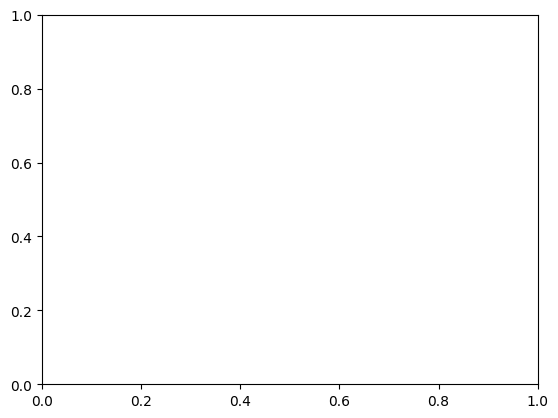

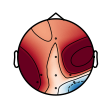

(<matplotlib.image.AxesImage at 0x7d4bf2920f70>,
 <matplotlib.colorbar.Colorbar at 0x7d4bf42cc610>)

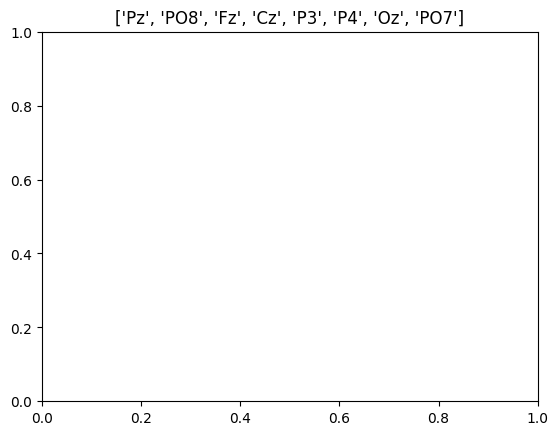

In [28]:
import plot_topo

channel_names = ["Fz", "Cz","Pz","Oz","P3","P4","PO7","PO8"]
shuffled_names = list(np.random.choice(channel_names, size = len(channel_names), replace = False))
plot_topo.plot_topo(channel_names = shuffled_names, channel_data = P3b_voltage, title = str(shuffled_names))